# 学習済みモデルの特徴空間・プロトタイプを可視化

In [1]:
from pathlib import Path
import os, sys, json
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
# 例: 物理GPU1番だけを見せる
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

In [4]:
# === プロジェクトルートの指定 ===
# Notebook を CIDL-main の直下で開いているなら "." で OK
PROJECT_ROOT = Path("/home/kouyou/ContinualLearning/repexp/PyCIL").resolve()
os.chdir(PROJECT_ROOT)
sys.path.append(str(PROJECT_ROOT))

from trainer import _set_device  # 既存のヘルパをそのまま使う
from utils.data_manager import DataManager
from utils import factory

# === 使いたい設定ファイルと、どの phase を可視化するか ===
CONFIG_PATH = "exps/der_mu/baseline0/cifar100_mu.json"   # 適宜変更
PHASE_ID    = 1                                               # ex) タスク3終了時のモデル → phase3.pkl

# === json 読み込み → args にする ===
with open(CONFIG_PATH) as f:
    args = json.load(f)

# device を training と同じ形式 (list of torch.device) に変換
_set_device(args)

print("model_name:", args["model_name"])
print("dataset   :", args["dataset"])
print("device    :", args["device"])

model_name: der-mu
dataset   : cifar100
device    : [device(type='cuda', index=1)]


## チェックポイントの設定

In [5]:
from glob import glob

def build_ckpt_dir(args, root=PROJECT_ROOT / "checkpoint"):
    
    """trainer / BaseLearner.save_checkpoint と同じ規則で checkpoint ディレクトリを作る"""
    init_cls = 0 if args ["init_cls"] == args["increment"] else args["init_cls"]
    log = "baseline" if "log" not in args else args["log"]
    
    ckpt_dir = "logs/{}/{}/{}/{}/{}/{}_{}_{}/".format(
        args["model_name"],
        log,
        args["dataset"],
        init_cls,
        args["increment"],
        args["prefix"], args["seed"][0], args["convnet_type"],
    )
    return ckpt_dir

ckpt_dir  = build_ckpt_dir(args)
ckpt_path = f"{ckpt_dir}/phase_{PHASE_ID}.pkl"

print("ckpt_dir :", ckpt_dir)
print("ckpt_path:", ckpt_path)

# # もし exists が False のときは、pattern で探す fallback も書いておくと楽
# if not ckpt_path.exists():
#     cand = glob(str(ckpt_dir / f"phase{PHASE_ID}*.pkl"))
#     print("fallback candidates:", cand)


ckpt_dir : logs/der-mu/baseline0/cifar100/0/10/cidl0_1993_resnet32/
ckpt_path: logs/der-mu/baseline0/cifar100/0/10/cidl0_1993_resnet32//phase_1.pkl


## データマネージャーとモデルの作成

In [6]:
# === DataManager & model を構築 ===
data_manager = DataManager(
    dataset_name=args["dataset"],
    shuffle=args["shuffle"],
    seed=args["seed"][0],
    init_cls=args["init_cls"],
    increment=args["increment"],
)

model = factory.get_model(args["model_name"], args)
model._network.to(args["device"][0])
model._device = args["device"][0]

# === checkpoint ロード ===
ckpt = torch.load(ckpt_path, map_location=model._device)
state_dict = ckpt["model_state_dict"]

# 1) checkpoint から fc の出力次元を読む
if "fc.weight" in state_dict:
    out_dim = state_dict["fc.weight"].shape[0]  # logits の次元数
    # 2) その次元数に合わせて fc を作成
    model._network.update_fc(out_dim)

# 3) その上で state_dict をロード
model._network.load_state_dict(state_dict)

# protos, forget_classes も保存されていれば復元
if "protos" in ckpt:
    model._protos = ckpt["protos"]
if "forget_classes" in ckpt and hasattr(model, "forget_classes"):
    model.forget_classes = ckpt["forget_classes"]

model.data_manager = data_manager

model.forget_classes = [0, 1]

print("loaded tasks =", ckpt.get("tasks", "N/A"))
print("forget_classes:", getattr(model, "forget_classes", None))


Files already downloaded and verified
Files already downloaded and verified


<ipython-input-6-fe9b394750ce>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=model._device)


RuntimeError: Error(s) in loading state_dict for DERNet:
	Unexpected key(s) in state_dict: "convnets.1.conv_1_3x3.weight", "convnets.1.bn_1.weight", "convnets.1.bn_1.bias", "convnets.1.bn_1.running_mean", "convnets.1.bn_1.running_var", "convnets.1.bn_1.num_batches_tracked", "convnets.1.stage_1.0.conv_a.weight", "convnets.1.stage_1.0.bn_a.weight", "convnets.1.stage_1.0.bn_a.bias", "convnets.1.stage_1.0.bn_a.running_mean", "convnets.1.stage_1.0.bn_a.running_var", "convnets.1.stage_1.0.bn_a.num_batches_tracked", "convnets.1.stage_1.0.conv_b.weight", "convnets.1.stage_1.0.bn_b.weight", "convnets.1.stage_1.0.bn_b.bias", "convnets.1.stage_1.0.bn_b.running_mean", "convnets.1.stage_1.0.bn_b.running_var", "convnets.1.stage_1.0.bn_b.num_batches_tracked", "convnets.1.stage_1.1.conv_a.weight", "convnets.1.stage_1.1.bn_a.weight", "convnets.1.stage_1.1.bn_a.bias", "convnets.1.stage_1.1.bn_a.running_mean", "convnets.1.stage_1.1.bn_a.running_var", "convnets.1.stage_1.1.bn_a.num_batches_tracked", "convnets.1.stage_1.1.conv_b.weight", "convnets.1.stage_1.1.bn_b.weight", "convnets.1.stage_1.1.bn_b.bias", "convnets.1.stage_1.1.bn_b.running_mean", "convnets.1.stage_1.1.bn_b.running_var", "convnets.1.stage_1.1.bn_b.num_batches_tracked", "convnets.1.stage_1.2.conv_a.weight", "convnets.1.stage_1.2.bn_a.weight", "convnets.1.stage_1.2.bn_a.bias", "convnets.1.stage_1.2.bn_a.running_mean", "convnets.1.stage_1.2.bn_a.running_var", "convnets.1.stage_1.2.bn_a.num_batches_tracked", "convnets.1.stage_1.2.conv_b.weight", "convnets.1.stage_1.2.bn_b.weight", "convnets.1.stage_1.2.bn_b.bias", "convnets.1.stage_1.2.bn_b.running_mean", "convnets.1.stage_1.2.bn_b.running_var", "convnets.1.stage_1.2.bn_b.num_batches_tracked", "convnets.1.stage_1.3.conv_a.weight", "convnets.1.stage_1.3.bn_a.weight", "convnets.1.stage_1.3.bn_a.bias", "convnets.1.stage_1.3.bn_a.running_mean", "convnets.1.stage_1.3.bn_a.running_var", "convnets.1.stage_1.3.bn_a.num_batches_tracked", "convnets.1.stage_1.3.conv_b.weight", "convnets.1.stage_1.3.bn_b.weight", "convnets.1.stage_1.3.bn_b.bias", "convnets.1.stage_1.3.bn_b.running_mean", "convnets.1.stage_1.3.bn_b.running_var", "convnets.1.stage_1.3.bn_b.num_batches_tracked", "convnets.1.stage_1.4.conv_a.weight", "convnets.1.stage_1.4.bn_a.weight", "convnets.1.stage_1.4.bn_a.bias", "convnets.1.stage_1.4.bn_a.running_mean", "convnets.1.stage_1.4.bn_a.running_var", "convnets.1.stage_1.4.bn_a.num_batches_tracked", "convnets.1.stage_1.4.conv_b.weight", "convnets.1.stage_1.4.bn_b.weight", "convnets.1.stage_1.4.bn_b.bias", "convnets.1.stage_1.4.bn_b.running_mean", "convnets.1.stage_1.4.bn_b.running_var", "convnets.1.stage_1.4.bn_b.num_batches_tracked", "convnets.1.stage_2.0.conv_a.weight", "convnets.1.stage_2.0.bn_a.weight", "convnets.1.stage_2.0.bn_a.bias", "convnets.1.stage_2.0.bn_a.running_mean", "convnets.1.stage_2.0.bn_a.running_var", "convnets.1.stage_2.0.bn_a.num_batches_tracked", "convnets.1.stage_2.0.conv_b.weight", "convnets.1.stage_2.0.bn_b.weight", "convnets.1.stage_2.0.bn_b.bias", "convnets.1.stage_2.0.bn_b.running_mean", "convnets.1.stage_2.0.bn_b.running_var", "convnets.1.stage_2.0.bn_b.num_batches_tracked", "convnets.1.stage_2.1.conv_a.weight", "convnets.1.stage_2.1.bn_a.weight", "convnets.1.stage_2.1.bn_a.bias", "convnets.1.stage_2.1.bn_a.running_mean", "convnets.1.stage_2.1.bn_a.running_var", "convnets.1.stage_2.1.bn_a.num_batches_tracked", "convnets.1.stage_2.1.conv_b.weight", "convnets.1.stage_2.1.bn_b.weight", "convnets.1.stage_2.1.bn_b.bias", "convnets.1.stage_2.1.bn_b.running_mean", "convnets.1.stage_2.1.bn_b.running_var", "convnets.1.stage_2.1.bn_b.num_batches_tracked", "convnets.1.stage_2.2.conv_a.weight", "convnets.1.stage_2.2.bn_a.weight", "convnets.1.stage_2.2.bn_a.bias", "convnets.1.stage_2.2.bn_a.running_mean", "convnets.1.stage_2.2.bn_a.running_var", "convnets.1.stage_2.2.bn_a.num_batches_tracked", "convnets.1.stage_2.2.conv_b.weight", "convnets.1.stage_2.2.bn_b.weight", "convnets.1.stage_2.2.bn_b.bias", "convnets.1.stage_2.2.bn_b.running_mean", "convnets.1.stage_2.2.bn_b.running_var", "convnets.1.stage_2.2.bn_b.num_batches_tracked", "convnets.1.stage_2.3.conv_a.weight", "convnets.1.stage_2.3.bn_a.weight", "convnets.1.stage_2.3.bn_a.bias", "convnets.1.stage_2.3.bn_a.running_mean", "convnets.1.stage_2.3.bn_a.running_var", "convnets.1.stage_2.3.bn_a.num_batches_tracked", "convnets.1.stage_2.3.conv_b.weight", "convnets.1.stage_2.3.bn_b.weight", "convnets.1.stage_2.3.bn_b.bias", "convnets.1.stage_2.3.bn_b.running_mean", "convnets.1.stage_2.3.bn_b.running_var", "convnets.1.stage_2.3.bn_b.num_batches_tracked", "convnets.1.stage_2.4.conv_a.weight", "convnets.1.stage_2.4.bn_a.weight", "convnets.1.stage_2.4.bn_a.bias", "convnets.1.stage_2.4.bn_a.running_mean", "convnets.1.stage_2.4.bn_a.running_var", "convnets.1.stage_2.4.bn_a.num_batches_tracked", "convnets.1.stage_2.4.conv_b.weight", "convnets.1.stage_2.4.bn_b.weight", "convnets.1.stage_2.4.bn_b.bias", "convnets.1.stage_2.4.bn_b.running_mean", "convnets.1.stage_2.4.bn_b.running_var", "convnets.1.stage_2.4.bn_b.num_batches_tracked", "convnets.1.stage_3.0.conv_a.weight", "convnets.1.stage_3.0.bn_a.weight", "convnets.1.stage_3.0.bn_a.bias", "convnets.1.stage_3.0.bn_a.running_mean", "convnets.1.stage_3.0.bn_a.running_var", "convnets.1.stage_3.0.bn_a.num_batches_tracked", "convnets.1.stage_3.0.conv_b.weight", "convnets.1.stage_3.0.bn_b.weight", "convnets.1.stage_3.0.bn_b.bias", "convnets.1.stage_3.0.bn_b.running_mean", "convnets.1.stage_3.0.bn_b.running_var", "convnets.1.stage_3.0.bn_b.num_batches_tracked", "convnets.1.stage_3.1.conv_a.weight", "convnets.1.stage_3.1.bn_a.weight", "convnets.1.stage_3.1.bn_a.bias", "convnets.1.stage_3.1.bn_a.running_mean", "convnets.1.stage_3.1.bn_a.running_var", "convnets.1.stage_3.1.bn_a.num_batches_tracked", "convnets.1.stage_3.1.conv_b.weight", "convnets.1.stage_3.1.bn_b.weight", "convnets.1.stage_3.1.bn_b.bias", "convnets.1.stage_3.1.bn_b.running_mean", "convnets.1.stage_3.1.bn_b.running_var", "convnets.1.stage_3.1.bn_b.num_batches_tracked", "convnets.1.stage_3.2.conv_a.weight", "convnets.1.stage_3.2.bn_a.weight", "convnets.1.stage_3.2.bn_a.bias", "convnets.1.stage_3.2.bn_a.running_mean", "convnets.1.stage_3.2.bn_a.running_var", "convnets.1.stage_3.2.bn_a.num_batches_tracked", "convnets.1.stage_3.2.conv_b.weight", "convnets.1.stage_3.2.bn_b.weight", "convnets.1.stage_3.2.bn_b.bias", "convnets.1.stage_3.2.bn_b.running_mean", "convnets.1.stage_3.2.bn_b.running_var", "convnets.1.stage_3.2.bn_b.num_batches_tracked", "convnets.1.stage_3.3.conv_a.weight", "convnets.1.stage_3.3.bn_a.weight", "convnets.1.stage_3.3.bn_a.bias", "convnets.1.stage_3.3.bn_a.running_mean", "convnets.1.stage_3.3.bn_a.running_var", "convnets.1.stage_3.3.bn_a.num_batches_tracked", "convnets.1.stage_3.3.conv_b.weight", "convnets.1.stage_3.3.bn_b.weight", "convnets.1.stage_3.3.bn_b.bias", "convnets.1.stage_3.3.bn_b.running_mean", "convnets.1.stage_3.3.bn_b.running_var", "convnets.1.stage_3.3.bn_b.num_batches_tracked", "convnets.1.stage_3.4.conv_a.weight", "convnets.1.stage_3.4.bn_a.weight", "convnets.1.stage_3.4.bn_a.bias", "convnets.1.stage_3.4.bn_a.running_mean", "convnets.1.stage_3.4.bn_a.running_var", "convnets.1.stage_3.4.bn_a.num_batches_tracked", "convnets.1.stage_3.4.conv_b.weight", "convnets.1.stage_3.4.bn_b.weight", "convnets.1.stage_3.4.bn_b.bias", "convnets.1.stage_3.4.bn_b.running_mean", "convnets.1.stage_3.4.bn_b.running_var", "convnets.1.stage_3.4.bn_b.num_batches_tracked", "convnets.1.fc.weight", "convnets.1.fc.bias". 
	size mismatch for fc.weight: copying a param with shape torch.Size([20, 128]) from checkpoint, the shape in current model is torch.Size([20, 64]).
	size mismatch for aux_fc.weight: copying a param with shape torch.Size([11, 64]) from checkpoint, the shape in current model is torch.Size([21, 64]).
	size mismatch for aux_fc.bias: copying a param with shape torch.Size([11]) from checkpoint, the shape in current model is torch.Size([21]).

## 学習済みクラスなどの設定・確認

In [26]:
# === この phase で「見えている」クラス数を計算 ===
num_classes = args["init_cls"] + PHASE_ID * args["increment"]
num_classes = min(num_classes, data_manager.get_total_classnum())

# その時点での全クラス（モデルのラベル空間）
all_seen = np.arange(num_classes)

# MU 系モデルの場合：忘却クラス集合（relabel 後の ID）
forget_set = set(getattr(model, "forget_classes", []))

# 現在 phase で実際に存在する忘却クラスだけに絞る
forget = np.array(
    sorted([c for c in forget_set if c < num_classes]),
    dtype=int
)

# retain クラス = all_seen - forget
retain = np.setdiff1d(all_seen, forget)

print("num_classes :", num_classes)
print("all_seen    :", all_seen[:10], "... (total", len(all_seen), ")")
print("forget      :", forget)
print("retain      :", retain[:10], "... (total", len(retain), ")")


num_classes : 100
all_seen    : [0 1 2 3 4 5 6 7 8 9] ... (total 100 )
forget      : [0 1]
retain      : [ 2  3  4  5  6  7  8  9 10 11] ... (total 98 )


## 実画像の特徴量の取り出し

In [27]:
# "all" / "forget" / "retain" / "manual" から選ぶ
TARGET_MODE = "manual"   # ← ここを変える

# manual のときに使うクラスID（モデル側のラベル空間）
MANUAL_CLASSES = [0,1,2,3,4,5,6,7,8,9]   # 例: 最初の数クラスだけ

if TARGET_MODE == "all":
    target_classes = all_seen
elif TARGET_MODE == "forget":
    target_classes = forget
elif TARGET_MODE == "retain":
    target_classes = retain
elif TARGET_MODE == "manual":
    target_classes = np.array(MANUAL_CLASSES, dtype=int)
else:
    raise ValueError("Unknown TARGET_MODE:", TARGET_MODE)

print("target_classes:", target_classes)

from torch.utils.data import DataLoader

# === 指定したクラスだけの test データセット ===
test_dataset = data_manager.get_dataset(
    indices=target_classes,
    source="train",
    mode="test",
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=args["num_workers"],
    pin_memory=True,
)

# === 特徴抽出 ===
features, labels = model._extract_vectors(test_loader)  # features: (N, D), labels: (N,)
print("features:", features.shape, "labels:", labels.shape)

# 念のため：本当に target_classes だけか確認
print("unique labels in batch:", np.unique(labels))



target_classes: [0 1 2 3 4 5 6 7 8 9]
features: (5000, 64) labels: (5000,)
unique labels in batch: [0 1 2 3 4 5 6 7 8 9]


## t-sneによる次元削減

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# === subsample (特徴側だけ、必要なら) ===
max_points = 50000
if features.shape[0] > max_points:
    idx = np.random.choice(features.shape[0], max_points, replace=False)
    feat_vis = features[idx]
    labels_vis = labels[idx]
else:
    feat_vis = features
    labels_vis = labels

print("visualizing features:", feat_vis.shape[0])

X_tsne = feat_vis

# === t-SNE ===
tsne = TSNE(
    n_components=2,
    init="pca",
    random_state=0,
    perplexity=30,
    learning_rate=200,
)
X_2d = tsne.fit_transform(X_tsne)



# 実画像
feat_2d = X_2d[:feat_vis.shape[0]]





visualizing features: 5000


## 保存先のディレクトリを設定

In [29]:
from glob import glob

def build_plot_dir(args, root=PROJECT_ROOT / "checkpoint"):
    
    """trainer / BaseLearner.save_checkpoint と同じ規則で checkpoint ディレクトリを作る"""
    init_cls = 0 if args ["init_cls"] == args["increment"] else args["init_cls"]
    log = "baseline" if "log" not in args else args["log"]
    
    ckpt_dir = "logs/{}/{}/{}/{}/{}/{}_{}_{}/plot/".format(
        args["model_name"],
        log,
        args["dataset"],
        init_cls,
        args["increment"],
        args["prefix"], args["seed"][0], args["convnet_type"],
    )
    return ckpt_dir

plot_dir  = build_plot_dir(args)

print("plot_dir :", plot_dir)



plot_dir : logs/baseline-mu/baseline0/cifar100/0/10/cidl1_1993_resnet32/plot/


## 可視化と保存

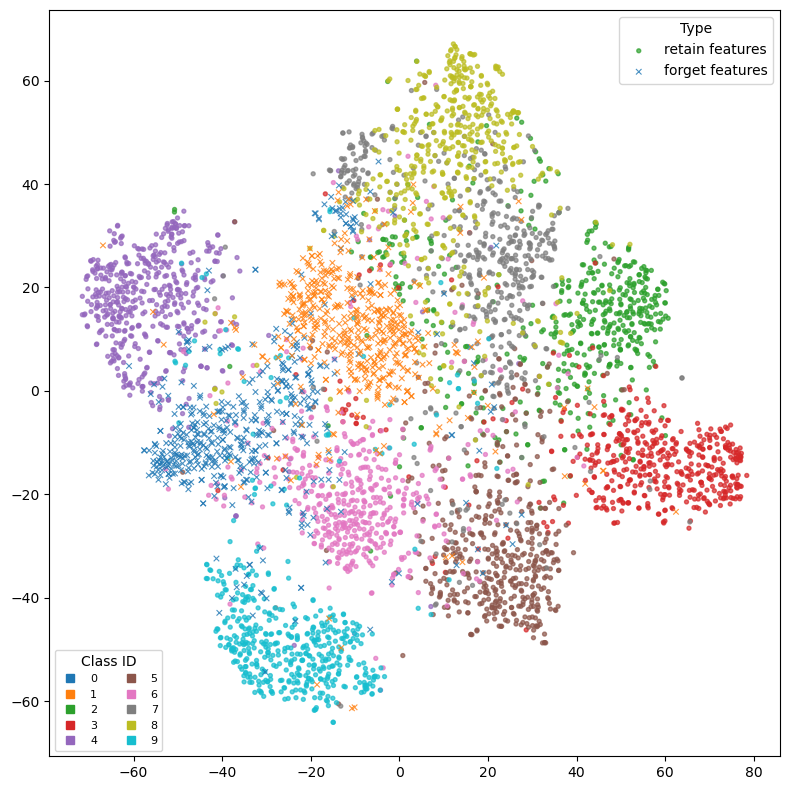

logs/baseline-mu/baseline0/cifar100/0/10/cidl1_1993_resnet32/plot/9_[0 1 2 3 4 5 6 7 8 9].pdf


In [30]:
from matplotlib.lines import Line2D  # まだインポートしてなければ追加

plt.figure(figsize=(8, 8))

# === 忘却クラス集合 ===
forget_set = set(getattr(model, "forget_classes", []))

# === 実画像 feature のうち忘却 / 維持に分割 ===
is_forget_feat = np.isin(labels_vis, list(forget_set))
idx_feat_forget = np.where(is_forget_feat)[0]
idx_feat_retain = np.where(~is_forget_feat)[0]


# === 色を割り当てる対象となる全クラスID ===
all_label_values = [labels_vis]


all_label_values = np.concatenate(all_label_values)
unique_labels = np.unique(all_label_values)

# === クラスごとの色をはっきり決める ===
# クラス数に応じて tab10 / tab20 を使い分け
if len(unique_labels) <= 10:
    cmap = plt.get_cmap("tab10")
else:
    cmap = plt.get_cmap("tab20")

# cls -> color の辞書
cls_color = {cls: cmap(i % cmap.N) for i, cls in enumerate(unique_labels)}

# === 維持クラスの実画像特徴（小さい丸） ===
if len(idx_feat_retain) > 0:
    colors_retain = [cls_color[int(lbl)] for lbl in labels_vis[idx_feat_retain]]
    plt.scatter(
        feat_2d[idx_feat_retain, 0],
        feat_2d[idx_feat_retain, 1],
        c=colors_retain,
        s=8,
        alpha=0.7,
        marker="o",
        label="retain features",
    )

# === 忘却クラスの実画像特徴（小さい ×） ===
if len(idx_feat_forget) > 0:
    colors_forget = [cls_color[int(lbl)] for lbl in labels_vis[idx_feat_forget]]
    plt.scatter(
        feat_2d[idx_feat_forget, 0],
        feat_2d[idx_feat_forget, 1],
        c=colors_forget,
        s=16,
        alpha=0.8,
        marker="x",
        linewidths=0.8,
        label="forget features",
    )



# === legend を2段構成にする ===
handles_type, labels_type = plt.gca().get_legend_handles_labels()
type_legend = plt.legend(
    handles_type,
    labels_type,
    loc="upper right",
    title="Type",
)
plt.gca().add_artist(type_legend)  # この legend を固定

# 2) クラスIDごとの色 legend
class_handles = []
for cls in unique_labels:
    h = Line2D(
        [], [],
        marker="s", linestyle="",
        color=cls_color[cls],
        label=str(cls),
    )
    class_handles.append(h)

plt.legend(
    handles=class_handles,
    loc="lower left",
    title="Class ID",
    ncol=2,          # クラス数に応じて調整
    fontsize=8,
)

# plt.title(f"Feature space with prototypes & DeepInv (phase {PHASE_ID}, mode={TARGET_MODE})")
plt.tight_layout()

# pdf として保存
save_name = f"{PHASE_ID}_{target_classes}.pdf"
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)
save_path = os.path.join(plot_dir, save_name)
plt.savefig(save_path)
plt.show()

print(save_path)